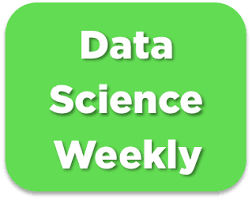

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

# Read file with labels

In [2]:
data = pd.read_csv('Sources/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [4]:
print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

No missing values. But there are somes outliers in age field (123 years old at max !!!).

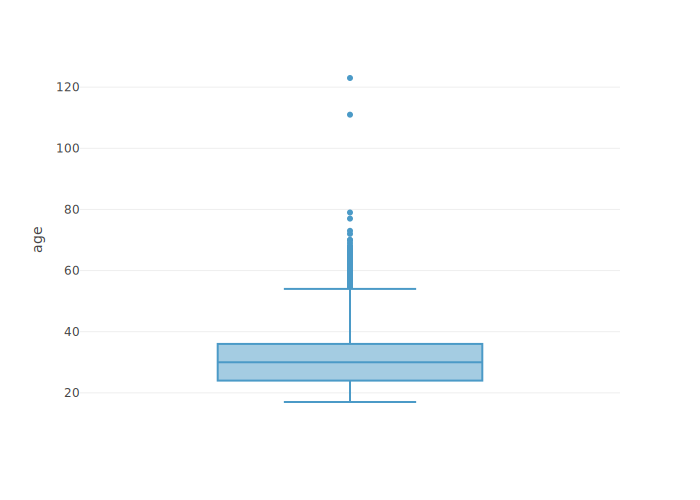

In [5]:
fig = px.box(data, y='age')
fig.show()

In [6]:
data.age.value_counts(dropna=False)

28     12972
30     12956
29     12710
27     12668
26     12525
31     12327
25     12157
32     12111
24     11647
33     11392
23     11097
34     10911
22     10471
35     10352
21      9870
36      9668
20      9131
37      8773
19      8452
38      8067
18      7662
39      7343
17      6825
40      6451
41      5783
42      5029
43      4423
44      3808
45      3249
46      2693
47      2255
48      1898
49      1467
50      1213
51       990
52       835
53       571
54       459
55       352
56       251
57       211
58       147
59       115
60        86
61        63
62        50
63        29
64        26
65        14
66         9
67         5
68         2
70         2
111        1
72         1
69         1
73         1
79         1
123        1
77         1
Name: age, dtype: int64

In [7]:
# We are going to remove age with more than 56 years old to train our model (less than mean * 3 sigma)
data = data[data['age'] < 56]
data.shape

(283563, 6)

In [8]:
data.to_csv('Sources/conversion_data_train_cleaned.csv', index=False)

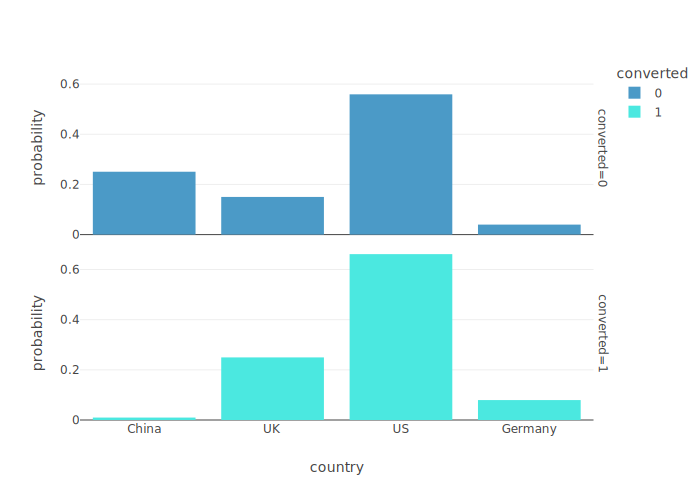

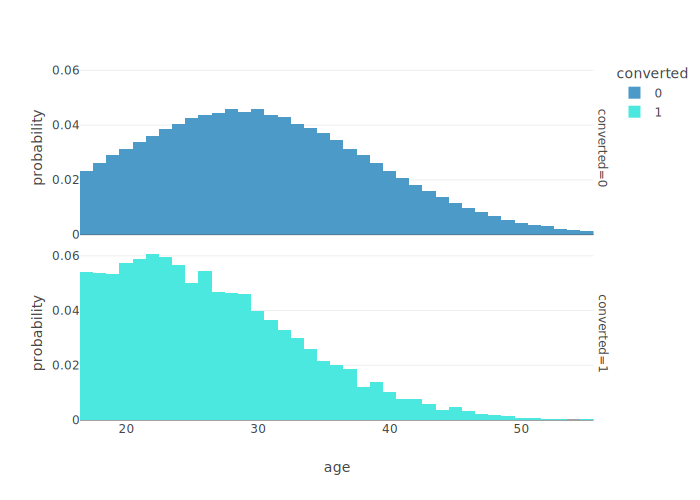

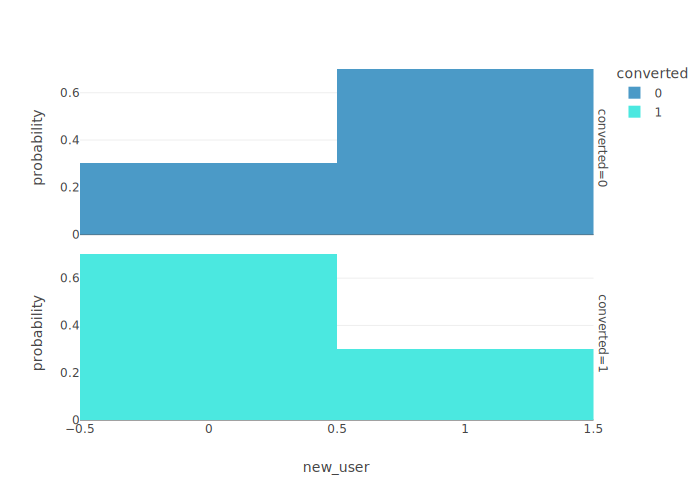

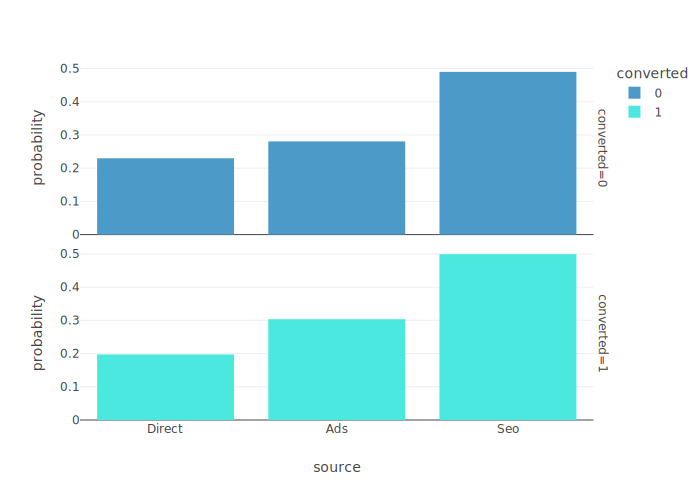

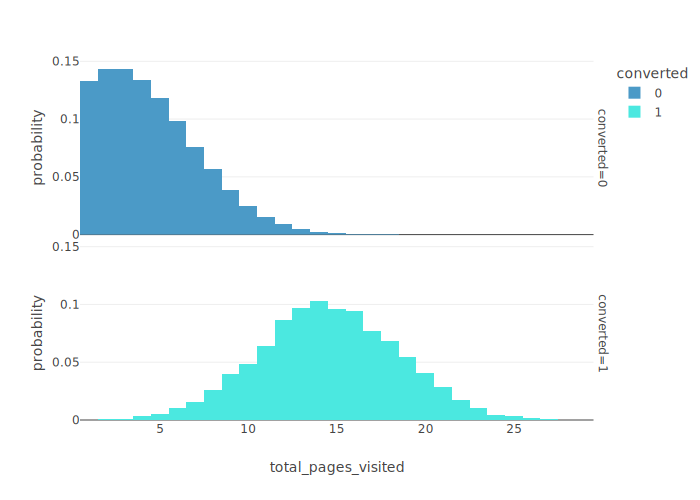

In [9]:
# Univariate analysis
# Distribution of each numeric variable
features = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
for f in features:
    fig = px.histogram(data, f, color = 'converted', facet_row = 'converted', histnorm = 'probability')
    fig.show()

Total pages visited seems to be good candidates to determine the converted data. Between 1 and pages visited => No conversion. More than 10 pages => conversion. 

C:\Users\ylequ\AppData\Local\Temp\ipykernel_21512\3715598394.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



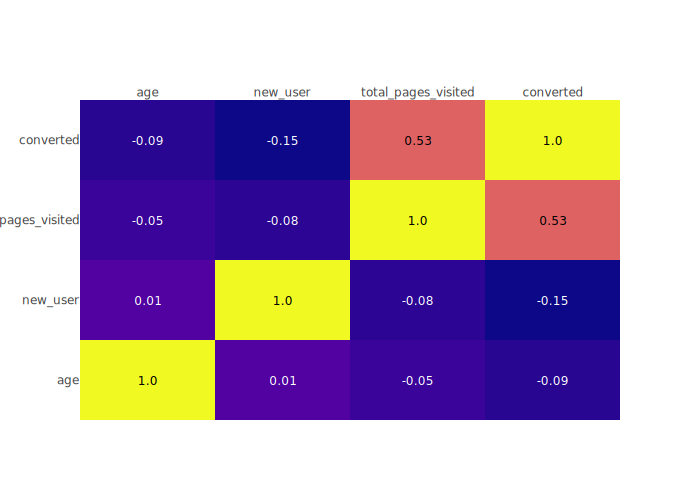

In [10]:
# Correlation matrix
corr_matrix = data.corr().round(2)
import plotly.figure_factory as ff
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

Correlation matrix indicates that total_pages_visited field is rather correlated with converted field.

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [11]:
features_list = ['total_pages_visited']
target_variable = 'converted'

In [12]:
X = data[features_list]
Y = data[target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



In [13]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [14]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.86007734]
 [ 0.03686198]
 [ 0.63482152]
 [ 0.33584175]
 [ 0.9338013 ]]


In [15]:
# Train model
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [16]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [17]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.33584175]
 [-0.26211779]
 [ 0.33584175]
 [-1.15905711]
 [ 0.9338013 ]]


In [18]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [19]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6971875218089191
f1-score on test set :  0.678594249201278


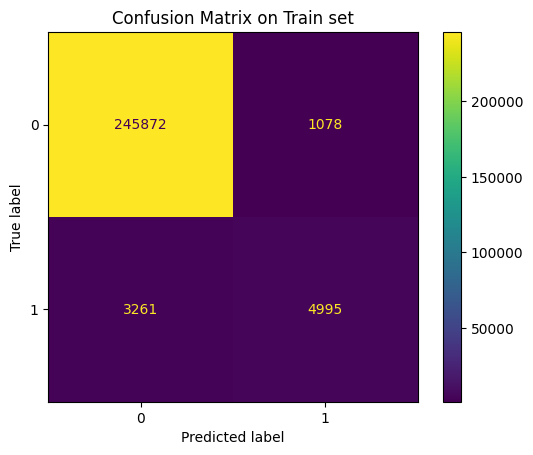

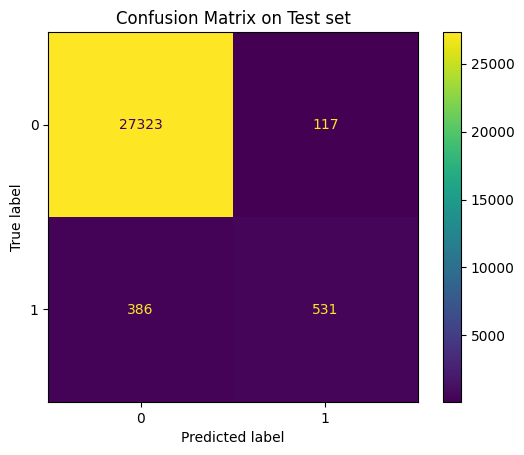

In [20]:
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [21]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression()

In [22]:
# Read data without labels
data_without_labels = pd.read_csv('Sources/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels[features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
#X_without_labels = X_without_labels.values
print("...Done")

#print(X_without_labels[0:5,:])
print(X_without_labels[0:5])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
   total_pages_visited
0                   16
1                    5
2                    1
3                    6
4                    3


In [23]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.32563947]
 [ 0.03686198]
 [-1.15905711]
 [ 0.33584175]
 [-0.56109756]]


In [24]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data_ = {'converted': classifier.predict(X_without_labels)}
Y_predictions = pd.DataFrame(columns=['converted'], data=data_)
Y_predictions.to_csv('Results/conversion_data_test_predictions_Logistic_Regression_1_feature.csv', index=False)

## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**

In [25]:
from time import time
df_results = pd.DataFrame(columns=['model', 'params', 'F1_Train', 'F1_Test', 'Time_consumed'])
result_count=0

In [26]:
target = 'converted'
X = data.drop(target, axis=1)
Y = data[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)

numeric_features = ['new_user', 'total_pages_visited', 'age']
categorical_features = ['country', 'source']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop='first')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [27]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [28]:
s = time()
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
df_results.loc[result_count]= ['RandomForestClassifier', classifier.get_params(), round(f1_score(Y_train, Y_train_pred), 4), round(f1_score(Y_test, Y_test_pred), 4), round(time()-s, 2)]
result_count+=1

f1-score on train set :  0.8007994670219855
f1-score on test set :  0.7383685800604228


In [29]:
df_results

,model,params,F1_Train,F1_Test,Time_consumed
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.8008,0.7384,16.83


This is better with a RandomForestClassifier model.

In [30]:
s = time()
from sklearn.model_selection import GridSearchCV
# Perform grid search
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [12],
    'min_samples_leaf': [10],
    'min_samples_split': [10],
    'n_estimators': [95],
    "bootstrap": [True],
    "warm_start": [True],
    "oob_score": [False],
    "criterion": ["gini"],
}
gridsearch = GridSearchCV(classifier, param_grid=params, cv=3, scoring='f1', n_jobs=-1, verbose=4)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1 score : ", gridsearch.best_score_)
print("F1 score on training set : ", gridsearch.score(X_train, Y_train))
print("F1 score on test set : ", gridsearch.score(X_test, Y_test))
df_results.loc[result_count]= ['RandomForestClassifier + GridSearchCV', gridsearch.best_params_, round(gridsearch.score(X_train, Y_train), 4), round(gridsearch.score(X_test, Y_test), 4), round(time()-s, 2)]
result_count+=1

Grid search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
...Done.
Best hyperparameters :  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 95, 'oob_score': False, 'warm_start': True}
Best F1 score :  0.7567394989176649
F1 score on training set :  0.7738485192860486
F1 score on test set :  0.752


In [31]:
df_results

,model,params,F1_Train,F1_Test,Time_consumed
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.8008,0.7384,16.83
1,RandomForestClassifier + GridSearchCV,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7738,0.7520,34.66


In [32]:
s = time()
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classifier = LinearDiscriminantAnalysis() # 
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
df_results.loc[result_count]= ['LinearDiscriminantAnalysis', classifier.get_params(), round(f1_score(Y_train, Y_train_pred), 4), round(f1_score(Y_test, Y_test_pred), 4), round(time()-s, 2)]
result_count+=1

f1-score on train set :  0.7522804507243784
f1-score on test set :  0.7579408543263966


In [33]:
df_results

,model,params,F1_Train,F1_Test,Time_consumed
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.8008,0.7384,16.83
1,RandomForestClassifier + GridSearchCV,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7738,0.7520,34.66
2,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.7523,0.7579,0.54


In [34]:
s = time()
from sklearn.model_selection import GridSearchCV
# Perform grid search
print("Grid search...")
classifier = LinearDiscriminantAnalysis()

# Grid of values to be tested
params = {'shrinkage': [None, 'auto', 0, 0.5, 1],
 'solver': ['svd', 'lsqr', 'eigen'],
 'store_covariance': [True, False],
 'tol': [0.0001]}
gridsearch = GridSearchCV(classifier, param_grid=params, cv=2, scoring='f1', n_jobs=-1, error_score=0, verbose=4)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1 score : ", gridsearch.best_score_)
print("F1 score on training set : ", gridsearch.score(X_train, Y_train))
print("F1 score on test set : ", gridsearch.score(X_test, Y_test))
df_results.loc[result_count]= ['LinearDiscriminantAnalysis + GridSearchCV', gridsearch.best_params_, round(gridsearch.score(X_train, Y_train), 4), round(gridsearch.score(X_test, Y_test), 4), round(time()-s, 2)]
result_count+=1

Grid search...
Fitting 2 folds for each of 30 candidates, totalling 60 fits


C:\Users\ylequ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


16 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ylequ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ylequ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py", line 615, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotImplementedError: shrinkage not support

...Done.
Best hyperparameters :  {'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True, 'tol': 0.0001}
Best F1 score :  0.7524587139778819
F1 score on training set :  0.7522804507243784
F1 score on test set :  0.7579408543263966


In [35]:
df_results

,model,params,F1_Train,F1_Test,Time_consumed
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.8008,0.7384,16.83
1,RandomForestClassifier + GridSearchCV,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7738,0.7520,34.66
2,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.7523,0.7579,0.54
3,LinearDiscriminantAnalysis + GridSearchCV,"{'shrinkage': 'auto', 'solver': 'lsqr', 'store...",0.7523,0.7579,4.88


In [36]:
s = time()
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier() 
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
df_results.loc[result_count]= ['ExtraTreesClassifier', classifier.get_params(), round(f1_score(Y_train, Y_train_pred), 4), round(f1_score(Y_test, Y_test_pred), 4), round(time()-s, 2)]
result_count+=1

f1-score on train set :  0.7966539717083788
f1-score on test set :  0.7279457125231338


In [37]:
s = time()
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier() 
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
df_results.loc[result_count]= ['DecisionTreeClassifier', classifier.get_params(), round(f1_score(Y_train, Y_train_pred), 4), round(f1_score(Y_test, Y_test_pred), 4), round(time()-s, 2)]
result_count+=1

f1-score on train set :  0.7966539717083788
f1-score on test set :  0.7300613496932514


In [38]:
df_results

,model,params,F1_Train,F1_Test,Time_consumed
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.8008,0.7384,16.83
1,RandomForestClassifier + GridSearchCV,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7738,0.7520,34.66
2,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.7523,0.7579,0.54
3,LinearDiscriminantAnalysis + GridSearchCV,"{'shrinkage': 'auto', 'solver': 'lsqr', 'store...",0.7523,0.7579,4.88
4,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.7967,0.7279,19.04
5,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.7967,0.7301,0.82


In [39]:
s = time()
from sklearn.tree import DecisionTreeClassifier
# Perform grid search
print("Grid search...")
classifier = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3, scoring='f1', n_jobs=-1, error_score=0, verbose=4)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1 score : ", gridsearch.best_score_)
print()
print("F1 score on training set : ", gridsearch.score(X_train, Y_train))
print("F1 score on test set : ", gridsearch.score(X_test, Y_test))
df_results.loc[result_count]= ['DecisionTreeClassifier + GridSearchCV', gridsearch.best_params_, round(gridsearch.score(X_train, Y_train), 4), round(gridsearch.score(X_test, Y_test), 4), round(time()-s, 2)]
result_count+=1

Grid search...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 4}
Best F1 score :  0.7504825472379609

F1 score on training set :  0.7591459268325854
F1 score on test set :  0.7371714643304129


In [40]:
df_results

,model,params,F1_Train,F1_Test,Time_consumed
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.8008,0.7384,16.83
1,RandomForestClassifier + GridSearchCV,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7738,0.7520,34.66
2,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.7523,0.7579,0.54
3,LinearDiscriminantAnalysis + GridSearchCV,"{'shrinkage': 'auto', 'solver': 'lsqr', 'store...",0.7523,0.7579,4.88
4,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.7967,0.7279,19.04
5,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.7967,0.7301,0.82
6,DecisionTreeClassifier + GridSearchCV,"{'max_depth': 8, 'min_samples_leaf': 1, 'min_s...",0.7591,0.7372,13.17


In [41]:
s = time()
from xgboost import XGBClassifier
classifier = XGBClassifier() 
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
df_results.loc[result_count]= ['XGBClassifier', classifier.get_params(), round(f1_score(Y_train, Y_train_pred), 4), round(f1_score(Y_test, Y_test_pred), 4), round(time()-s, 2)]
result_count+=1

f1-score on train set :  0.7746205789931137
f1-score on test set :  0.7469135802469136


In [42]:
df_results

,model,params,F1_Train,F1_Test,Time_consumed
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.8008,0.7384,16.83
1,RandomForestClassifier + GridSearchCV,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7738,0.7520,34.66
2,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.7523,0.7579,0.54
3,LinearDiscriminantAnalysis + GridSearchCV,"{'shrinkage': 'auto', 'solver': 'lsqr', 'store...",0.7523,0.7579,4.88
4,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.7967,0.7279,19.04
5,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.7967,0.7301,0.82
6,DecisionTreeClassifier + GridSearchCV,"{'max_depth': 8, 'min_samples_leaf': 1, 'min_s...",0.7591,0.7372,13.17
7,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.7746,0.7469,6.40


In [43]:
s = time()
from xgboost import XGBClassifier
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

params = {
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [2, 3, 4],
    'n_estimators': [6, 8, 10, 12, 14, 16, 18, 20]
}
gridsearch = GridSearchCV(xgboost, param_grid = params, cv = 3, scoring='f1', n_jobs=-1, error_score=0, verbose=4)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1 score : ", gridsearch.best_score_)
print()
print("F1 score on training set : ", gridsearch.score(X_train, Y_train))
print("F1 score on test set : ", gridsearch.score(X_test, Y_test))
df_results.loc[result_count]= ['XGBClassifier + GridSearchCV', gridsearch.best_params_, round(gridsearch.score(X_train, Y_train), 4), round(gridsearch.score(X_test, Y_test), 4), round(time()-s, 2)]
result_count+=1

Grid search...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
...Done.
Best hyperparameters :  {'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 20}
Best F1 score :  0.7649837757440267

F1 score on training set :  0.7698333665272521
F1 score on test set :  0.7536764705882352


In [44]:
s = time()
from sklearn.linear_model import SGDClassifier
#classifier = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
classifier = SGDClassifier(random_state=42)
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
df_results.loc[result_count]= ['SGDClassifier', classifier.get_params(), round(f1_score(Y_train, Y_train_pred), 4), round(f1_score(Y_test, Y_test_pred), 4), round(time()-s, 2)]
result_count+=1

f1-score on train set :  0.7656853603303583
f1-score on test set :  0.7571865443425075


In [45]:
s = time()
from sklearn.model_selection import GridSearchCV
# Perform grid search
print("Grid search...")
classifier = SGDClassifier(random_state=42)

# Grid of values to be tested
params = {
    #'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'loss': ['log_loss'],
    #'alpha': [0.0001, 0.0002, 0.0003],
    'alpha': [0.0002],
    #'max_iter': [1000, 900, 1100],
    'max_iter': [1000],
    'tol': [1e-3],
    #'penalty': [None, 'l2', 'l1', 'elasticnet']
    'penalty': [None],
}
gridsearch = GridSearchCV(classifier, param_grid=params, cv=3, scoring='f1', n_jobs=-1, verbose=4)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1 score : ", gridsearch.best_score_)
print("F1 score on training set : ", gridsearch.score(X_train, Y_train))
print("F1 score on test set : ", gridsearch.score(X_test, Y_test))
df_results.loc[result_count]= ['SGDClassifier + GridSearchCV', gridsearch.best_params_, round(gridsearch.score(X_train, Y_train), 4), round(gridsearch.score(X_test, Y_test), 4), round(time()-s, 2)]
result_count+=1

Grid search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
...Done.
Best hyperparameters :  {'alpha': 0.0002, 'loss': 'log_loss', 'max_iter': 1000, 'penalty': None, 'tol': 0.001}
Best F1 score :  0.7623374274146505
F1 score on training set :  0.765090811965812
F1 score on test set :  0.7584097859327216


In [46]:
df_results.sort_values('F1_Test', ascending = False)

,model,params,F1_Train,F1_Test,Time_consumed
10,SGDClassifier + GridSearchCV,"{'alpha': 0.0002, 'loss': 'log_loss', 'max_ite...",0.7651,0.7584,1.01
2,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.7523,0.7579,0.54
3,LinearDiscriminantAnalysis + GridSearchCV,"{'shrinkage': 'auto', 'solver': 'lsqr', 'store...",0.7523,0.7579,4.88
9,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.7657,0.7572,0.46
8,XGBClassifier + GridSearchCV,"{'max_depth': 6, 'min_child_weight': 3, 'n_est...",0.7698,0.7537,131.50
1,RandomForestClassifier + GridSearchCV,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7738,0.7520,34.66
7,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.7746,0.7469,6.40
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.8008,0.7384,16.83
6,DecisionTreeClassifier + GridSearchCV,"{'max_depth': 8, 'min_samples_leaf': 1, 'min_s...",0.7591,0.7372,13.17
5,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.7967,0.7301,0.82


## Best model found is SGDClassifier (with parameter found with GridSearchCV). F1 score : Train = 0.7651, Test = 0.7584 with best execution time !
Let's save it !

In [47]:
# Read data without labels
features_list = numeric_features + categorical_features
print("Features are:", features_list)
data_without_labels = pd.read_csv('Sources/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)
X_without_labels = data_without_labels[features_list]
X_without_labels = preprocessor.transform(X_without_labels)

Features are: ['new_user', 'total_pages_visited', 'age', 'country', 'source']
Prediction set (without labels) : (31620, 5)


In [48]:
classifier = SGDClassifier(random_state=42, loss='log_loss', alpha=0.0002, max_iter=1000, tol=1e-3, penalty=None)
classifier.fit(X_train, Y_train)
data_ = {'converted': classifier.predict(X_without_labels)}
Y_predictions = pd.DataFrame(columns=['converted'], data=data_)
filename='Results/conversion_data_test_predictions_SGDClassifier_All_features.csv'
Y_predictions.to_csv(filename, index=False)
print('Results saved as:', filename)

Results saved as: Results/conversion_data_test_predictions_SGDClassifier_All_features.csv


## Coefficients study and model process on only two important features

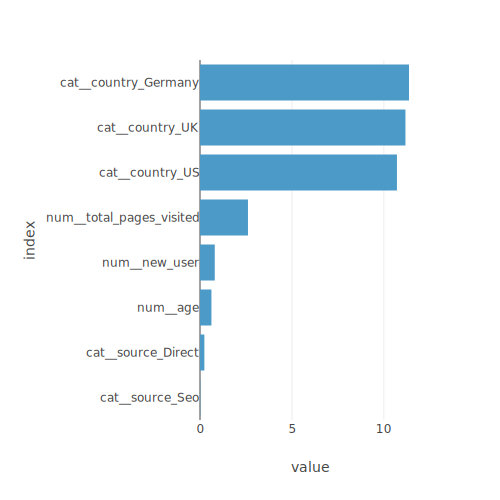

In [49]:
df_coefs = pd.DataFrame(index = preprocessor.get_feature_names_out(), data = classifier.coef_.transpose(), columns=["coefficients"])
feature_importance = abs(df_coefs).sort_values(by = 'coefficients')
feature_importance
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, margin = {'l': 200}, width=500, height=500)
fig.show()

We keep only two features that matter : total_pages_visited & country

In [50]:
# We keep only two features that matter : total_pages_visited & country
# And we retry to process data with it.
target = 'converted'
removed_features = ['new_user', 'age', 'source']
data = pd.read_csv('Sources/conversion_data_train.csv')
X = data.drop([target]+removed_features, axis=1)
Y = data[target]
print(X.head(5))
print(Y.head(5))

   country  total_pages_visited
0    China                    2
1       UK                    3
2  Germany                   14
3       US                    3
4       US                    3
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64


In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)

numeric_features = ['total_pages_visited']
categorical_features = ['country']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop='first')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [52]:
s = time()
classifier = SGDClassifier(random_state=42)
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7110829103214891
f1-score on test set :  0.6918158567774936


This is not better with only two important features.

## Let's use StackingClassifier !  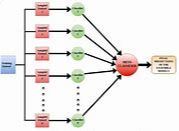

Definition: Stack of estimators with a final classifier. Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

Then, let's take our best classifiers with default values and let's combine it to create a meta classifier with the help of the StackingClassifier class.

In [110]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('Sources/conversion_data_train.csv')
data = data[data['age'] < 56]

target = 'converted'
X = data.drop(target, axis=1)
Y = data[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)

preprocessor = ColumnTransformer(transformers=[
    ('numeric', Pipeline(steps=[
        ('imputer', SimpleImputer()), 
        ('scaler', StandardScaler())]), 
     pd.Index(['age', 'new_user', 'total_pages_visited'], dtype='object'))
  , 
    ('categorical', Pipeline(steps=[
      ('imputer', SimpleImputer(fill_value='missing', strategy='constant')), 
      ('encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), 
     pd.Index(['country', 'source'], dtype='object'))
  ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [111]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

s = time()

dt_estimator = DecisionTreeClassifier(random_state= 0)
sgd_estimator = SGDClassifier(n_jobs= -1, random_state=0)
rf_estimator = RandomForestClassifier(n_jobs= -1, random_state= 0)
lr_estimator = LogisticRegression(n_jobs= -1, random_state=0)

estimators = [('sc1', dt_estimator), ('sc2', rf_estimator), ('sc3', sgd_estimator)]
classifier = StackingClassifier(estimators=estimators, final_estimator=lr_estimator)

classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)
print(f"It took {round(time()-s, 2)} seconds to achieve !")
print("")
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))


It took 36.7 seconds to achieve !

f1-score on train set :  0.773047645897942
f1-score on test set :  0.7735091743119265


## BINGO ! F1 score : Train = 0.7730, Test = 0.7735
Let's save it !

In [112]:
# Read data without labels
features_list = numeric_features + categorical_features
print("Features are:", features_list)
data_without_labels = pd.read_csv('Sources/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)
X_without_labels = data_without_labels[features_list]
X_without_labels = preprocessor.transform(X_without_labels)

Features are: ['new_user', 'total_pages_visited', 'age', 'country', 'source']
Prediction set (without labels) : (31620, 5)


In [113]:
classifier.fit(X_train, Y_train)
data_ = {'converted': classifier.predict(X_without_labels)}
Y_predictions = pd.DataFrame(columns=['converted'], data=data_)
filename='Results/conversion_data_test_predictions_StackingClassifier_All_features.csv'
Y_predictions.to_csv(filename, index=False)
print('Results saved as:', filename)

Results saved as: Results/conversion_data_test_predictions_StackingClassifier_All_features.csv


## This is the **Results/conversion_data_test_predictions_StackingClassifier_All_features.csv** file to assess for verifications.